In [1]:
!pip install --no-index --no-deps /kaggle/input/lavis-pretrained/salesforce-lavis/transformers* 
!pip install --no-index --no-deps /kaggle/input/lavis-pretrained/salesforce-lavis/hugging*
import torch

Processing /kaggle/input/lavis-pretrained/salesforce-lavis/transformers-4.26.1-py3-none-any.whl
  Attempting uninstall: transformers
    Found existing installation: transformers 4.27.4
    Uninstalling transformers-4.27.4:
      Successfully uninstalled transformers-4.27.4
Processing /kaggle/input/lavis-pretrained/salesforce-lavis/huggingface_hub-0.12.0-py3-none-any.whl
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.13.3
    Uninstalling huggingface-hub-0.13.3:
      Successfully uninstalled huggingface-hub-0.13.3


>**Credits Section:**
> This notebook was made possible by incorporating serveral parts of other public notebooks.
> - [[Pytorch] BLIP Training](https://www.kaggle.com/code/debarshichanda/pytorch-blip-training) By [Debarshi Chanda](https://www.kaggle.com/debarshichanda)
> - [Post-Processing: Adding Modifiers](https://www.kaggle.com/code/yawata/post-processing-adding-modifiers) By [kyoukuntaro](https://www.kaggle.com/yawata)

## BLIP Large - Training & Inference
This notebook serves as a simple baseline for training and inference with [BLIP Large](https://huggingface.co/Salesforce/blip-image-captioning-large) model.

**BLIP: Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation**

<img src ="https://s3.amazonaws.com/moonup/production/uploads/1670928184033-62441d1d9fdefb55a0b7d12c.gif">

BLIP Models are models designed to **Caption images: Generate a simple text describing what is in the image** which is exactly the reverse operation of text->image that is used in stable diffusion.




### Training or Inference?

This notebook supports two modes of opertation: Training & Inference (Since we can't use the internet when submitting).
This flag is used to switch between the two different modes.

In [6]:
TRAINING = False

**Training Configuration**

In [7]:
EPOCHS = 1
SEED = 2023
T_MAX = 500
MIN_LR = 1e-6
N_ACCUMULATE = 1
WEIGHT_DECAY = 1e-6
LEARNING_RATE = 1e-4
VALID_BATCH_SIZE = 1
TRAIN_BATCH_SIZE = 4
SCHEDULER = 'CosineAnnealingLR'
DATASET = 'poloclub/diffusiondb'
MODEL_NAME = "Salesforce/blip-image-captioning-large"
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
VAL_DEVICE = torch.device("cpu")

**Inference Configuration**

In [8]:
BATCH_SIZE = 16
EMBEDDING_LENGTH = 384
TRAINED_MODEL_PATH = '/kaggle/input/blip-trained-large/blip_trained_large.pt'
OFFLINE_BACKBONE_PATH = "/kaggle/input/blip-pretrained-model/blip-image-captioning-large"
SENTENCE_TRANSFORMERS_MODEL = '/kaggle/input/sentence-transformers-222/all-MiniLM-L6-v2'

### Mode 1: Training

In [9]:
import os
import gc
import copy
import time
import torch
import joblib
import random
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from datasets import load_dataset
from collections import defaultdict
from torch.optim import lr_scheduler
from transformers import AutoProcessor, AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import BlipForConditionalGeneration
import warnings; warnings.filterwarnings("ignore")
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TOKENIZERS_PARALLELISM'] = "False"

In [10]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False    
    os.environ['PYTHONHASHSEED'] = str(seed)    
set_seed(SEED)

In [11]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor
    def __len__(self): return len(self.dataset)
    def __getitem__(self, idx):
        item = self.dataset[idx]
        return {k:v.squeeze() for k,v in self.processor(images=item["image"], text=item["prompt"], padding="max_length", return_tensors="pt").items()}

### Training Functions
- **Train one epoch:** Trains one epoch.
- **Validate one epoch:** Runs a validation run for one epoch over the dataset.
- **Run Training:** Run full training (multiple epochs) over the dataset.

In [12]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()    
    dataset_size = 0
    running_loss = 0.0    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        input_ids = data['input_ids'].to(device)
        pixel_values = data['pixel_values'].to(device)        
        batch_size = input_ids.size(0)
        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=input_ids)                
        loss = outputs.loss
        loss = loss / N_ACCUMULATE
        loss.backward()    
        if (step + 1) % N_ACCUMULATE == 0:
            optimizer.step()            
            optimizer.zero_grad()
            if scheduler is not None: scheduler.step()                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size        
        epoch_loss = running_loss / dataset_size        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, LR=optimizer.param_groups[0]['lr'])
    gc.collect()    
    return epoch_loss

In [12]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()    
    dataset_size = 0
    running_loss = 0.0    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        input_ids = data['input_ids'].to(device)
        pixel_values = data['pixel_values'].to(device)        
        batch_size = input_ids.size(0)
        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=input_ids)                
        loss = outputs.loss        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size        
        epoch_loss = running_loss / dataset_size        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, LR=optimizer.param_groups[0]['lr'])    
    gc.collect()    
    return epoch_loss

In [14]:
def run_training(model, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf    
    for epoch in range(1, num_epochs + 1): 
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, dataloader=train_loader, device=DEVICE, epoch=epoch)
        val_epoch_loss = valid_one_epoch(model, valid_loader, device=DEVICE, epoch=epoch)
        if val_epoch_loss <= best_epoch_loss:
            print(f"Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss            
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f"BestLoss.bin")
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    model.load_state_dict(best_model_wts)    
    return model

#### Loading the Dataset

In [13]:
if not TRAINING:
    processor = AutoProcessor.from_pretrained(MODEL_NAME)
    dataset = load_dataset(DATASET, '2m_first_5k')
    dataset = dataset['train']
    dataset = dataset.filter(lambda example: example["step"] == 50)
    dataset = dataset.train_test_split(test_size=0.2)
    train_dataset = ImageCaptioningDataset(dataset['train'], processor)
    valid_dataset = ImageCaptioningDataset(dataset['test'], processor)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=TRAIN_BATCH_SIZE)
    valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=VALID_BATCH_SIZE)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset diffusion_db downloaded and prepared to /root/.cache/huggingface/datasets/poloclub___diffusion_db/2m_first_5k/0.9.1/547894e3a57aa647ead68c9faf148324098f47f2bc1ab6705d670721de9d89d1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

#### Loading & Training The Model

In [38]:
if TRAINING:
    model = BlipForConditionalGeneration.from_pretrained(MODEL_NAME)
    model.to(DEVICE)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=T_MAX, eta_min=MIN_LR)
    model = run_training(model, optimizer, scheduler, num_epochs=EPOCHS)
    del train_loader, valid_loader
    _ = gc.collect()
    torch.save(model.state_dict(), 'blip_trained_large.pt')

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 15.90 GiB total capacity; 14.70 GiB already allocated; 11.75 MiB free; 14.87 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Mode 2: Inference

In [14]:
def load_image_paths(image_dir, image_ids):
    image_path_list = []
    image_set = set()
    for image_id in image_ids:
        if image_id in image_set: continue
        image_set.add(image_id)
        image_path_list.append(f"{image_dir}/{image_id}.png")
    return image_path_list

def make_batches(l, batch_size=16):
    for i in range(0, len(l), batch_size):
        yield l[i:i + batch_size]

In [24]:
import sys; sys.path.append('../input/sentence-transformers-222/sentence-transformers')
import os
import sys
import cv2
import torch
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, models, util
from transformers import AutoProcessor, BlipForConditionalGeneration

In [16]:
if not TRAINING:
    comp_path = Path('/kaggle/input/stable-diffusion-image-to-prompts/')
    sample_submission = pd.read_csv(comp_path / 'sample_submission.csv', index_col='imgId_eId')

### Loading the trained BLIP model

In [17]:
if not TRAINING:
    processor = AutoProcessor.from_pretrained(OFFLINE_BACKBONE_PATH)
    model = BlipForConditionalGeneration.from_pretrained(OFFLINE_BACKBONE_PATH)
    model.load_state_dict(torch.load(TRAINED_MODEL_PATH))
    model.to(DEVICE)

aCosine Index calculation

In [25]:
all_predicted = []
all_ground = []

model.eval()    
bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
for step, data in bar:        
    input_ids = data['input_ids'].to(DEVICE)
    og_prompts = processor.batch_decode(input_ids, skip_special_tokens=True)
    pixel_values = data['pixel_values'].to(DEVICE)
    all_ground.append(og_prompts[0])
#     print(og_prompts)
    out = model.generate(pixel_values=pixel_values, max_length=20, min_length=5)
    prompts = processor.batch_decode(out, skip_special_tokens=True)
    all_predicted.append(prompts[0])
#     print(prompts)
#     loss = outputs.loss        
#     running_loss += (loss.item() * batch_size)
#     dataset_size += batch_size        
#     epoch_loss = running_loss / dataset_size        
#     bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, LR=optimizer.param_groups[0]['lr'])    
# gc.collect()

st_model = SentenceTransformer(SENTENCE_TRANSFORMERS_MODEL)
e1 = st_model.encode(all_predicted)
e2 = st_model.encode(all_ground)

scores = util.cos_sim(e1, e2)
final = 0
for i in range(len(scores)):
    final += scores[i][i]
final /= len(scores)

print(final)

100%|██████████| 997/997 [09:47<00:00,  1.70it/s]


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

tensor(0.6392)


#### Testing out the full pipeline using a single image

['a robot drawing of a robot']


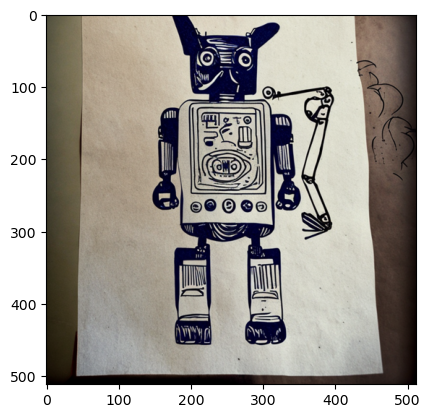

In [58]:
if not TRAINING:
    image_path_list = load_image_paths("/kaggle/input/stable-diffusion-image-to-prompts/images", [val.split("_")[0] for val in sample_submission.index])
    raw_image = Image.open(image_path_list[3]).convert("RGB")
    plt.imshow(raw_image)
    pixel_values = processor(images=[raw_image], return_tensors="pt").pixel_values.to(DEVICE)
    out = model.generate(pixel_values=pixel_values, max_length=20, min_length=5)
    prompts = processor.batch_decode(out, skip_special_tokens=True)
    print(prompts)

#### Preparing our sentence transformer model

In [19]:
if not TRAINING:
    st_model = SentenceTransformer(SENTENCE_TRANSFORMERS_MODEL)
    images = os.listdir(comp_path/"images")
    image_ids = [i.split('.')[0] for i in images]
    eIds = list(range(EMBEDDING_LENGTH))
    imgId_eId = [
        '_'.join(map(str, i)) for i in zip(
            np.repeat(image_ids, EMBEDDING_LENGTH),
            np.tile(range(EMBEDDING_LENGTH), len(image_ids)))]

#### Making Predictions

In [49]:
import matplotlib.pyplot as plt

if not TRAINING:
    submissions = []
    for batch in make_batches(images, BATCH_SIZE):
        images_batch = []
        for i, image in enumerate(batch): images_batch.append(Image.open(comp_path/"images"/image).convert("RGB"))
        pixel_values = processor(images = images_batch, return_tensors="pt").pixel_values.to(DEVICE)
        out = model.generate(pixel_values=pixel_values, max_length=20, min_length=5)
        prompts = processor.batch_decode(out, skip_special_tokens=True)
        prompts = [p for p in prompts]
        embeddings = st_model.encode(prompts).flatten()
        submissions.extend(embeddings)

Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening '/tmp/tmp39ifhu01.PNG'
Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening '/tmp/tmpzzw7n6l_.PNG'
Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [39]:


print(prompts)

["a man looking at a pizza he made out of pizza, he's telling them that he", 'a dinosaur jn 4 q in the woods, trending on artstation, central composition,', 'a robot drawing of a robot', 'a portal to another dimension, surreal, highly detailed, artstation, smooth, sharp focus,', 'astronaut doing the moon walk backwards', 'a huge huge wooden carving circular sculpture of a rose thorn garden, intricate details, photograph, sharp', 'a portrait painting of tyrell mission']


#### Submission

In [21]:
if not TRAINING:
    submission = pd.DataFrame({"imgId_eId":imgId_eId, "val": submissions})
    submission.to_csv("submission.csv", index=False)
    sample_submission.head()